In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from experiments.helpers import plot_all, print_metrics

np.random.seed(42)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data Loading and Feature Construction

In [2]:
df_train = pd.read_csv('./dataset/house_price_train.csv', parse_dates=["Time"])
df_test = pd.read_csv('./dataset/house_price_test.csv', parse_dates=["Time"])

In [3]:
# construct features
cat_columns = ["City", "District", "Street", "Community", "Floor"]
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_columns = ["#Floors", "#Rooms", "#Halls", "Area"]
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# this will only load the selected columns, so we don't need to drop unused columns
preprocessor = ColumnTransformer(
    n_jobs=4,
    transformers=[
        ("num", num_transformer, num_columns),
        ("cat", cat_transformer, cat_columns)
])

In [4]:
# standardize price
scaler = StandardScaler()
scaler.fit(df_train["Price"].values.reshape(-1, 1))

df_train["Price"] = scaler.transform(df_train["Price"].values.reshape(-1, 1))
df_test["Price"] = scaler.transform(df_test["Price"].values.reshape(-1, 1))

In [5]:
X_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1].values
X_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1].values

### Linear Regression

In [6]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])
baseline_model.fit(X_train, y_train)

joblib.dump(baseline_model, "models/linear-regression.joblib")

['linear-regression.joblib']

In [7]:
predicted = baseline_model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  -19356.550806331234
Max:  231630.9176702595
R2:  0.7367825353481969
MAPE:  0.23546976668985847
Log MAE:  nan


/home/fahmi/lomba/ieee-cyberc/experiments/helpers.py:10: RuntimeWarning: invalid value encountered in log
  return np.mean(np.abs(np.log(y_true) - np.log(y_pred)))


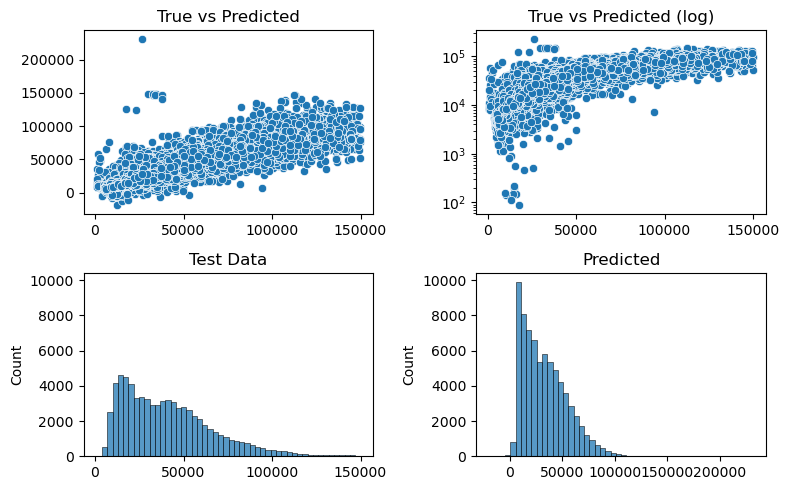

In [8]:
plot_all(y_true_unscaled, predicted_unscaled)
plt.show()

### Decision Tree

In [9]:
tree_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", DecisionTreeRegressor())
])
tree_model.fit(X_train, y_train)

joblib.dump(tree_model, "models/decision_tree.joblib")

['decision_tree.joblib']

In [10]:
predicted = tree_model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  1018.9999999999964
Max:  150000.0
R2:  0.6432743264301184
MAPE:  0.2549389345873793
Log MAE:  0.31229648931280446


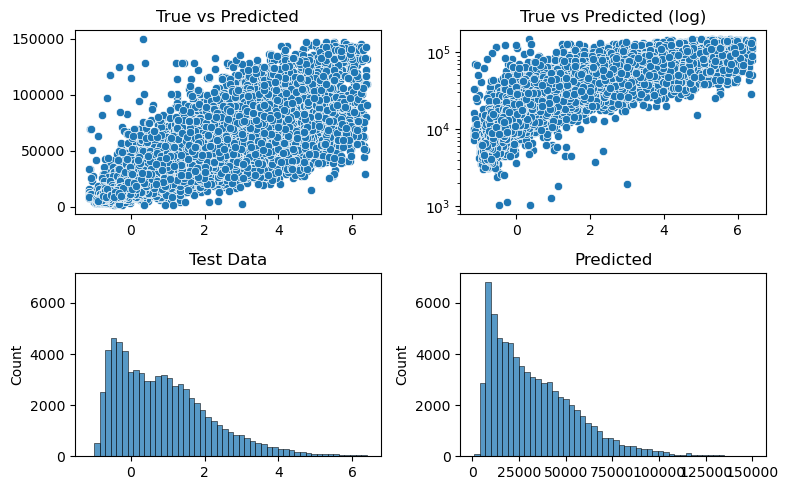

In [11]:
plot_all(df_test["Price"].values, predicted_unscaled)
plt.show()

### Random Forest

In [12]:
random_forest_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, max_depth=16, n_jobs=4))
])
random_forest_model.fit(X_train, y_train)

joblib.dump(random_forest_model, "models/random_forest.joblib")

['random_forest.joblib']

In [13]:
predicted = random_forest_model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(predicted.reshape(-1, 1))
y_true_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

print_metrics(y_true_unscaled, predicted_unscaled)

Min:  5144.233614994486
Max:  136630.51532137155
R2:  0.663719776792965
MAPE:  0.2653091382999831
Log MAE:  0.310102764557435


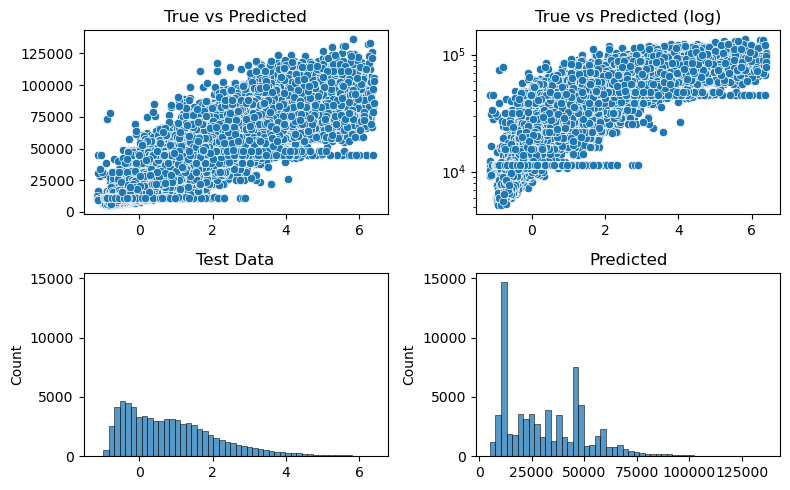

In [14]:
plot_all(df_test["Price"].values, predicted_unscaled)
plt.show()